In [1]:
import json
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize

In [2]:
all_data = json.load(open("data.json"))
extracted = []
is_stable = {}
mc = []
for date, data in all_data.items():
    weekly = {"date": date}
    m = {"date": date}
    for coin in data:
        weekly[coin["name"]] = coin["quote"]["USD"]["price"]
        is_stable[coin["name"]] =  "stablecoin" in coin["tags"]
        m[coin["name"]] = coin["quote"]["USD"]["market_cap"]
    extracted.append(weekly)
    mc.append(m)
df  = pd.DataFrame.from_records(extracted)
df['date']= pd.to_datetime(df['date'])
df = df.set_index('date')


market_cap = pd.DataFrame.from_records(mc)
market_cap["date"] = pd.to_datetime(market_cap['date'])
market_cap= market_cap.set_index('date')

delete_list = ["UNUS SED LEO","Revain","Celsius"] 

for c in df.columns:
    if is_stable[c] or c in delete_list:
        del df[c]
        del market_cap[c]

In [458]:
all_data["20210509"][0]

{'id': 1,
 'name': 'Bitcoin',
 'symbol': 'BTC',
 'slug': 'bitcoin',
 'num_market_pairs': 9525,
 'date_added': '2013-04-28T00:00:00.000Z',
 'tags': ['mineable',
  'pow',
  'sha-256',
  'store-of-value',
  'state-channels',
  'coinbase-ventures-portfolio',
  'three-arrows-capital-portfolio',
  'polychain-capital-portfolio',
  'binance-labs-portfolio',
  'arrington-xrp-capital',
  'blockchain-capital-portfolio',
  'boostvc-portfolio',
  'cms-holdings-portfolio',
  'dcg-portfolio',
  'dragonfly-capital-portfolio',
  'electric-capital-portfolio',
  'fabric-ventures-portfolio',
  'framework-ventures',
  'galaxy-digital-portfolio',
  'huobi-capital',
  'alameda-research-portfolio',
  'a16z-portfolio',
  '1confirmation-portfolio',
  'winklevoss-capital',
  'usv-portfolio',
  'placeholder-ventures-portfolio',
  'pantera-capital-portfolio',
  'multicoin-capital-portfolio',
  'paradigm-xzy-screener'],
 'max_supply': 21000000,
 'circulating_supply': 18705156,
 'total_supply': 18705156,
 'platform'

In [451]:
"Tether" in df.columns

False

In [434]:
last_year_market_cap = market_cap.iloc[-52].dropna()
weight_by_market_cap = np.array(last_year_market_cap / last_year_market_cap.sum())

In [436]:
annual_returns, annual_cov = get_annual_returns_and_covariances(df, -52, None, drop_na=False, coins=list(last_year_market_cap.index))


r,v = get_returns_and_volatility(annual_returns,weight_by_market_cap, annual_cov)

print("Returns: ", r, "Volatility: ", v)

print(get_allocation(weight_by_market_cap, annual_returns))

Returns:  2.286860904349846 Volatility:  4.805880916559545
              allocation
Binance Coin         1.0
Bitcoin             67.0
Bitcoin Cash         2.0
Bitcoin SV           1.0
Cardano              1.0
EOS                  1.0
Ethereum             9.0
Litecoin             1.0
Stellar              1.0
Tether               3.0
Tezos                1.0
XRP                  3.0


In [8]:


def get_annual_returns_and_covariances(df, start_index, end_index,drop_na=True,coins=None):
      
    if end_index:
        timeframe = df.iloc[start_index:end_index]
    else:
        timeframe = df.iloc[start_index:]
    if coins:
        for c in timeframe.columns:
            if c not in coins:
                del timeframe[c]
    if drop_na:
        timeframe = timeframe.dropna(axis=1, how="any")
    returns_weekly = timeframe.pct_change()
    returns_annual = returns_weekly.mean() * len(timeframe)
    cov_weekly = returns_weekly.cov()
    cov_annual = cov_weekly * len(timeframe)
    return returns_annual,cov_annual

In [9]:

def calculate_best_portfolio_for_timeframe(df, start_index, end_index=None):
    
    annual_returns, annual_cov = get_annual_returns_and_covariances(df, start_index, end_index)
    weights = maxSR(annual_returns, annual_cov).x
    r,v = get_returns_and_volatility(annual_returns, weights, annual_cov)
    allocation = get_allocation(weights,annual_returns)
    print("Average Annual Returns: ", r)
    print("Volatility: ",v)
    print(allocation)


In [10]:
def calculate_efficient_frontier_for_timeframe(df, start_index, end_index=None):
    
    
    annual_returns, annual_cov = get_annual_returns_and_covariances(df, start_index, end_index)
    efficient_weights = get_efficient_weights(annual_returns, annual_cov)
    
    max_sharp_allocation = None
    sharp = -np.inf
    for weights in efficient_weights:
        r,v = get_returns_and_volatility(annual_returns, weights, annual_cov)
        allocation = get_allocation(weights,annual_returns)
        print("Average Annual Returns: ", r)
        print("Volatility: ",v)
        print("Sharp: ", r/v)
        if r/v > sharp:
            sharp = r/v
            max_sharp_allocation = allocation
        #print(allocation)
    return sharp, max_sharp_allocation


In [11]:

def get_max_sharp_allocations(df, start_and_end):
    
    max_sharp_allocations = []
    sharps = []
    for start,end in start_and_end:
        print(start,end)
        sharp,allocation = calculate_efficient_frontier_for_timeframe(df, start,end_index=end)
        max_sharp_allocations.append(allocation)
        sharps.append(sharp)

    return max_sharp_allocations

In [22]:

max_sharp_allocations = get_max_sharp_allocations(df,[(-48,-36), (-36,24),(-24,-12), (-12,None)])

weights = [1,1,1,1]

weighted_allocations = [ m*w for m,w in zip(max_sharp_allocations, weights)]
summed = pd.concat(weighted_allocations, axis=1).sum(axis=1) 


normed =   summed / summed.sum()

below_1_percent = normed[normed >= 0.01] 

renormed = below_1_percent / below_1_percent.sum()
renormed 


-48 -36


NameError: name 'get_returns_and_volatility' is not defined

In [530]:
percent_market_cap = [ m for c,m in c_m  ]

percent_market_cap / sum(percent_market_cap)

array([1.32612695e-03, 2.49748733e-03, 1.22400390e-01, 7.54194643e-01,
       2.66095881e-03, 4.93944162e-04, 6.33117407e-03, 6.04415557e-04,
       1.43531041e-02, 5.61808703e-03, 3.59541128e-03, 7.70807147e-04,
       2.00338681e-02, 1.98109450e-02, 7.11765223e-03, 3.38196446e-03,
       2.49207044e-02, 5.50766833e-03, 4.38064805e-03])

In [519]:
pd.concat(max_sharp_allocations, axis=1)

/home/cehmann/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,allocation,allocation,allocation
Arweave,NaN,0.315643,0.233166
Bitcoin Diamond,NaN,0.032139,0.047138
Cardano,NaN,NaN,0.117392
Decentraland,0.010570,NaN,0.005140
Dogecoin,0.021602,0.047991,0.034081
Ethereum,0.111857,NaN,NaN
Ethereum Classic,NaN,NaN,0.006681
Fantom,NaN,0.027586,NaN
Harmony,NaN,NaN,0.020172
Helium,NaN,NaN,0.006129


In [484]:
combined

,allocation
Arweave,32278.0
Bitcoin Diamond,32280.0
Chainlink,32278.0
Decentraland,32278.0
Dogecoin,32278.0
Enjin Coin,32278.0
Ethereum,32278.0
Ethereum Classic,32279.0
Fantom,32278.0
Horizen,32278.0


In [21]:
def get_random_weights(n):
    
    weights = np.random.random(n)
    weights /= np.sum(weights)    
    return weights

def combis_and_volatility( returns_annual, weights, covariance ):
    
    returns = weights @ returns_annual
    volatility = np.sqrt(weights.T @ (covariance @ weights)) * np.sqrt(52)
    return returns, volatility


def negative_return(weights,returns_annual, covariance):
    r,v = get_returns_and_volatility( returns_annual, weights, covariance )
    return -r

def positive_return(weights,returns_annual, covariance):
    r,v = get_returns_and_volatility( returns_annual, weights, covariance )
    return r


def volatility(weights,returns_annual,covariance):
    
    r,v = get_returns_and_volatility( returns_annual, weights, covariance )
    return v


# risk free rate from germany https://www.statista.com/statistics/885915/average-risk-free-rate-select-countries-europe/
def sharp_ratio(r,v, risk_free_rate=0.008 ):
    return (r - risk_free_rate) / v 

def negative_sharp_ratio(r,v,risk_free_rate=0.008):
    
    return -sharp_ratio(r,v,risk_free_rate=risk_free_rate
                       )
# need to put weights in front for optimizer
def negative_sharp_of_portfolio(weights,returns_annual, covariance, risk_free_rate):
    r,v = get_returns_and_volatility(returns_annual, weights, covariance)
    return negative_sharp_ratio(r,v,risk_free_rate=risk_free_rate)
    

In [280]:
get_returns_and_volatility( returns_annual,  np.ones(75)/75, cov_annual)

(3.694917032049072, 7.137696011739017)

In [275]:

# sample weights and plot
all_weights = []
all_returns = []
all_volatilities = []
all_sharp = []
for _ in range(100000):
    
    weights = get_random_weights(len(returns_annual))
    returns,volatility = get_returns_and_volatility(returns_annual, weights,cov_annual)
    all_weights.append(weights)
    all_returns.append(returns)
    all_volatilities.append(volatility)
    all_sharp.append(sharp_ratio(returns,volatility))

    


In [84]:
max_sharp_index = np.array(all_sharp).argmax()
max_weights = all_weights[max_sharp_index]

In [85]:
for c,w in zip(last_year.columns,max_weights):
    if w > 0.001:Bitcoin           14.0
Celsius           14.0
Chainlink          4.0
Dogecoin           1.0
Enjin Coin         1.0
Monero            25.0
NEM               14.0
Nexo               8.0
Numeraire          1.0
Quant             11.0
        print (c,w)

Algorand 0.003349785728448174
Aragon 0.003652106271136682
Ardor 0.015186819008627957
Augur 0.010090139819632353
Basic Attention Token 0.014102957299243575
Binance Coin 0.003583147270267668
Binance USD 0.016426438782395008
BitShares 0.005863856480811021
BitTorrent 0.012472455907149555
Bitcoin 0.016922269035245557
Bitcoin Cash 0.020246538656275098
Bitcoin Diamond 0.0035805588864244254
Bitcoin Gold 0.013878959128626458
Bitcoin SV 0.010622532970582927
Cardano 0.015850474937518136
Celsius 0.020977704270411946
Chainlink 0.02318078646521234
Chiliz 0.015428831568849463
Cosmos 0.023384861479331318
Dash 0.0020105450293566203
Decentraland 0.019533261442998023
Decred 0.003042467309607576
DigiByte 0.01468491533896374
Dogecoin 0.023646907999450392
EOS 0.015778685924467538
Enjin Coin 0.014452877181327506
Ethereum 0.023250201350361502
Ethereum Classic 0.014360200419263688
FTX Token 0.0025383096684963202
Golem 0.005721923128429793
HUSD 0.0185528002951007
Hedera Hashgraph 0.010813451373072122
Holo 0.003

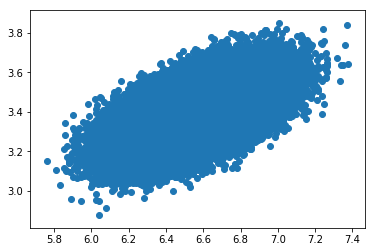

In [79]:
plt.scatter(all_volatilities,all_returns)
plt.show()

In [13]:
def maxSR(meanReturns, covMatrix, riskFreeRate = 0.008, constraintSet=(0,1)):
    "Minimize the negative SR, by altering the weights of the portfolio"
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = minimize(negative_sharp_of_portfolio, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [14]:
def minimizeVariance(meanReturns, covMatrix, riskFreeRate = 0.008, constraintSet=(0,1)):
    "Minimize the negative SR, by altering the weights of the portfolio"
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = minimize(volatility, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [15]:
def maxReturn(meanReturns, covMatrix, riskFreeRate = 0.008, constraintSet=(0,1)):
    "Minimize the negative SR, by altering the weights of the portfolio"
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = minimize(negative_return, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [16]:
def efficientOpt(meanReturns, covMatrix, returnTarget, constraintSet=(0,1)):
    """For each returnTarget, we want to optimise the portfolio for min variance"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)

    constraints = ({'type':'eq', 'fun': lambda x: positive_return(x, meanReturns, covMatrix) - returnTarget},
                    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    effOpt = minimize(volatility, numAssets*[1./numAssets], args=args, method = 'SLSQP', bounds=bounds, constraints=constraints)
    return effOpt

In [17]:
weights

NameError: name 'weights' is not defined

In [18]:
def get_allocation(weights, meanReturns):
    allocation = pd.DataFrame(weights, index=copy.deepcopy(meanReturns.index), columns=['allocation'])
    #allocation["allocation"]  = [round(i*100,0) for i in allocation["allocation"]]    
    return allocation[allocation ["allocation"] >= 0.001]

In [334]:
def calculatedResults(meanReturns, covMatrix):
    """Read in mean, cov matrix, and other financial information
        Output, Max SR , Min Volatility, efficient frontier """
    # Max Return Ratio Portfolio
    maxSR_Portfolio = maxReturn(meanReturns, covMatrix)
    maxSR_returns, maxSR_std = get_returns_and_volatility(meanReturns,maxSR_Portfolio['x'], covMatrix)
    #maxSR_returns, maxSR_std = round(maxSR_returns*100,2), round(maxSR_std*100,2)
    maxSR_allocation = get_allocation(maxSR_Portfolio['x'], meanReturns)
    print("Max return:", maxSR_returns, maxSR_std)

    # Min Volatility Portfolio
    minVol_Portfolio = minimizeVariance(meanReturns, covMatrix)
    minVol_returns, minVol_std = get_returns_and_volatility(meanReturns,minVol_Portfolio['x'], covMatrix)
    #minVol_returns, minVol_std = round(minVol_returns*100,2), round(minVol_std*100,2)
    minVol_allocation = pd.DataFrame(minVol_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    minVol_allocation.allocation = [round(i*100,0) for i in minVol_allocation.allocation]

    print("MIn vol:", minVol_returns, minVol_std)
    # Efficient Frontier
    efficientList = []
    targetReturns = np.linspace(minVol_returns, maxSR_returns, 20)
    print(targetReturns)
    for target in targetReturns:
        efficientList.append(efficientOpt(meanReturns, covMatrix, target))

    return maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, targetReturns, efficientList







In [19]:
def get_efficient_weights(meanReturns, covMatrix):
    """Read in mean, cov matrix, and other financial information
        Output, Max SR , Min Volatility, efficient frontier """
    # Max Return Ratio Portfolio
    maxSR_Portfolio = maxReturn(meanReturns, covMatrix)
    maxSR_returns, maxSR_std = get_returns_and_volatility(meanReturns,maxSR_Portfolio['x'], covMatrix)
    #maxSR_returns, maxSR_std = round(maxSR_returns*100,2), round(maxSR_std*100,2)
    maxSR_allocation = get_allocation(maxSR_Portfolio['x'], meanReturns)

    # Min Volatility Portfolio
    minVol_Portfolio = minimizeVariance(meanReturns, covMatrix)
    minVol_returns, minVol_std = get_returns_and_volatility(meanReturns,minVol_Portfolio['x'], covMatrix)
    #minVol_returns, minVol_std = round(minVol_returns*100,2), round(minVol_std*100,2)
    minVol_allocation = pd.DataFrame(minVol_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    minVol_allocation.allocation = [round(i*100,0) for i in minVol_allocation.allocation]

    # Efficient Frontier
    efficientList = []
    targetReturns = np.linspace(minVol_returns, maxSR_returns, 20)
    for target in targetReturns:
        efficientList.append(efficientOpt(meanReturns, covMatrix, target))

    return  [ e.x for e in efficientList]







In [338]:
import copy
for r,p in zip(efficientReturns, efficientList):
    print(r,v)
    print(get_allocation(copy.deepcopy(p.x), returns_annual))

3.379982980625427 3.01588159313401
            allocation
Bitcoin           14.0
Celsius           14.0
Chainlink          4.0
Dogecoin           1.0
Enjin Coin         1.0
Monero            25.0
NEM               14.0
Nexo               8.0
Numeraire          1.0
Quant             11.0
THETA              6.0
3.7585214167116634 3.01588159313401
              allocation
Celsius             18.0
Chainlink            5.0
Decentraland         1.0
Dogecoin             1.0
Enjin Coin           1.0
Ethereum             3.0
Monero              25.0
NEM                 16.0
Nexo                10.0
Quant               11.0
THETA                8.0
4.137059852797899 3.01588159313401
              allocation
Celsius             22.0
Chainlink            3.0
Chiliz               1.0
Decentraland         3.0
Dogecoin             2.0
Horizen              2.0
Monero              18.0
NEM                 17.0
Nexo                11.0
Quant                9.0
THETA                8.0
Waves             

In [150]:
for c,w in zip(last_year.columns,result.x):
    if w > 0.001:
        print (c,w)

Dogecoin 0.9999999999998674


In [134]:
r,v = get_returns_and_volatility(returns_annual, result.x, cov_annual)
print(r,v)

1.1103010926628554 3.01588159313401


In [ ]:
#simulate Bitcoin by sampling from the return
import numpy as np


bitcoin_weekly = np.array(returns_weekly["Bitcoin"].iloc[1:])

all_samples = []

for _ in range(1000):
    val = 100
    for i in range(51):    
        val *= 1 + bitcoin_weekly[np.random.randint(0,len(bitcoin_weekly))]

    all_samples.append(val)
print(np.mean(all_samples))
